# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 



## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 



In [3]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy 
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')




/Users/Blaven/miniconda3/envs/ADS500B/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# add any additional libaries you need here
import warnings
warnings.filterwarnings('ignore')



In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [9]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))



<AxesSubplot:xlabel='category'>

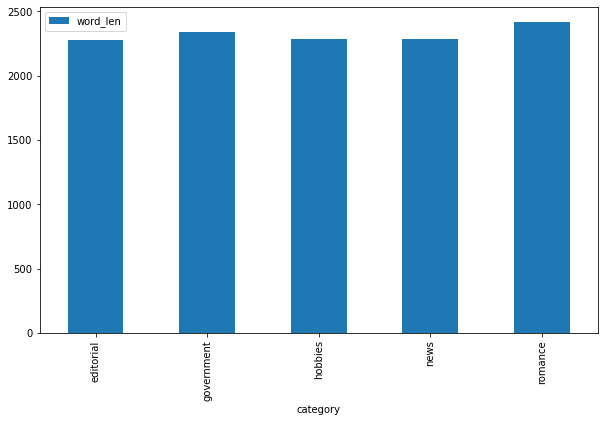

In [10]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [11]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [12]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The remaining words without stopwords and also removes 70% of words that are frequent and remove infrequent words that show up less than 5 times

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [13]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [14]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 



In [15]:
# Your code here
#mentioned on the slack channle yesterday 10:39 to get list of prob
print(W_text_matrix)

[[1.68337451e-01 0.00000000e+00 1.96650289e-01 0.00000000e+00
  2.85979276e-02]
 [3.21768971e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.73861343e-01 4.04032928e-02 0.00000000e+00 0.00000000e+00
  1.42067891e-03]
 [2.70374263e-01 0.00000000e+00 4.84640057e-02 0.00000000e+00
  3.45461946e-04]
 [2.00522708e-01 2.22367923e-03 1.11484682e-01 0.00000000e+00
  1.76090573e-02]
 [2.11291613e-01 0.00000000e+00 8.87307055e-02 9.29325030e-04
  2.07559028e-02]
 [2.39704893e-01 0.00000000e+00 7.71591194e-02 0.00000000e+00
  0.00000000e+00]
 [4.34471662e-02 2.87037924e-01 1.12596363e-02 3.20322556e-02
  0.00000000e+00]
 [7.61577235e-02 1.30072967e-01 1.70359708e-02 1.12493847e-01
  8.49672694e-03]
 [0.00000000e+00 1.80889286e-01 6.80731716e-02 0.00000000e+00
  1.92867857e-01]
 [2.96245644e-01 0.00000000e+00 0.00000000e+00 1.28064526e-02
  0.00000000e+00]
 [1.00062501e-01 6.20328596e-02 2.80806775e-02 8.41639230e-02
  2.48976118e-02]
 [5.62709467e-03 1.54002561e-01 1.362582

In [16]:
# convert to list at end of df 
df['nmf.topic']= [W_text_matrix[i].tolist().index(W_text_matrix[i].max()) for i in range(len(df))]
df

,category,id,text,char_len,word_len,nmf.topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0
...,...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339,2
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233,2
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,2
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,2


In [17]:
#NMF topic categories tally
df.groupby('nmf.topic')['category'].value_counts()


nmf.topic  category  
0          editorial     20
           news           8
           government     4
1          romance       29
           hobbies        8
           editorial      4
2          government    26
           hobbies       26
           news          11
           editorial      2
3          news          17
           hobbies        1
4          news           8
           editorial      1
           hobbies        1
Name: category, dtype: int64

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: <!-- Your answer here -->  They are a little diffrent in how the topics categorized the articles. Which is why we lost categories from the oringal Brown in NMF due to percent value of words and commonality.


## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 

In [18]:
# Your code here
#https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_




In [19]:
# call display_topics on your model

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names())






Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


In [20]:

#create lsa_topic at end of df 
df['lsa_topic']= [W_svd_para_matrix[i].tolist().index(W_svd_para_matrix[i].max()) for i in range(len(df))]
df

,category,id,text,char_len,word_len,nmf.topic,lsa_topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2,0
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0,0
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0,0
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0,0
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0,0
...,...,...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339,2,0
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233,2,0
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,2,0
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,2,0


In [21]:
#group by topics and count values
df.groupby('lsa_topic')['category'].value_counts()



lsa_topic  category  
0          hobbies       36
           news          34
           government    30
           editorial     27
           romance       21
1          romance        8
3          news           3
4          news           7
Name: category, dtype: int64

Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The LSA model is similar as the NMF model when compared to the Brown when looking at categories type.

Q: What is your interpretation of the display topics output? 

A:  My guess is that topic 0 was really common in the article format due to common words.Also topic 2 got absorbed by the other topics. 1,3,4 defaulted to 1 category due to how heavy the weights were. The book also mentioned something about the realitve sizes of the words consitute the topics relevance.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:

# Fit your LDA model here


lda_para_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

In [23]:
# Call `display_topics` on your fitted model here

display_topics(lda_para_model, tfidf_text_vectorizer.get_feature_names())




Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


In [24]:
# The count
df['lda_topic']= [W_lda_para_matrix[i].tolist().index(W_lda_para_matrix[i].max()) for i in range(len(df))]
df

,category,id,text,char_len,word_len,nmf.topic,lsa_topic,lda_topic
0,editorial,cb01,Assembly session brought much good The General...,12659,2200,2,0,2
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234,0,0,2
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244,0,0,2
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230,0,0,2
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241,0,0,2
...,...,...,...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339,2,0,1
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233,2,0,1
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300,2,0,0
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272,2,0,0


In [25]:
df.groupby('lda_topic')['category'].value_counts()


lda_topic  category  
0          hobbies       16
           news           9
           editorial      3
1          government    20
           hobbies       14
           news           3
           editorial      1
2          news          31
           editorial     22
           government     2
           hobbies        1
3          government     8
           hobbies        3
           news           1
4          romance       29
           hobbies        2
           editorial      1
Name: category, dtype: int64

Q: What inference do you draw from the displayed topics for your LDA model?

A: Topic 4 and topic 2 had alot of weight that will contain the articles within the LDA model. I'm not sure if I can tell the relations between the categories in the lda topic groups .

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: The numbers of of the five articles LDA matches up with the same number of articles as the brown category. The catergories in each topic seem balanced and are split due to the word weight.

In [26]:
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_text_vectors, count_text_vectorizer, sort_topics=False)


In [27]:
pyLDAvis.display(lda_display)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Topic 2 has alot of similarity with 3 and 4. Topic 5 and 1 are unique with its salient terms. Also 3 had the majoirty of topic terms tokens.